In [139]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import environments
import pandas as pd
import simulation_utils
from tqdm import tqdm
from models import ValueIterationNetwork, MCTS, GridWorldNode

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Example 1: Diffusion (random transitions) with Rewards in corners

In [2]:
# define the enviornment
n_rows, n_columns = 20, 20
grid_shape = (n_rows, n_columns)

sparse_diffusion_matrix = environments.make_diffision_transition_matrix(n_rows, n_columns, sparse=True)

R = np.ones(n_rows * n_columns) * 0
R[0] = 1.0
R[n_columns-1] = 1.0 
R[-1] = 1.0
R[-n_columns] = 1.0

gamma = 0.8
iterations = 10

# call the value iteration network
Q, V = ValueIterationNetwork.value_iteration(
    transition_functions = [sparse_diffusion_matrix],
    reward_functions = [R],
    n_rows = n_rows,
    n_columns = n_columns,
    gamma=gamma,
    iterations = iterations,
    return_interim_estimates = True
)


  0%|          | 0/10 [00:00<?, ?it/s]

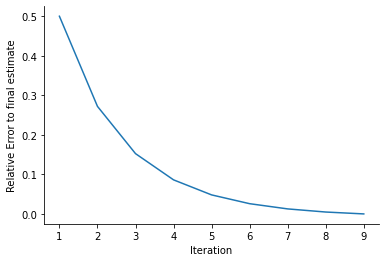

In [3]:
error = np.linalg.norm(V -  np.tile(V[-1,:], (iterations, 1)), axis=1)
plt.plot(np.arange(1, len(error)), error[1:] / np.max(error))
plt.ylabel('Relative Error to final estimate')
plt.xlabel('Iteration')
sns.despine()

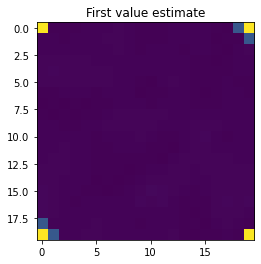

In [4]:
plt.imshow(V[0, :].reshape(grid_shape), cmap='viridis')
plt.title('First value estimate')
plt.savefig('2dDrift_v0.pdf', dpi=300)

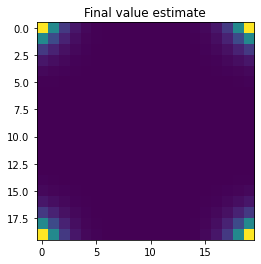

In [5]:
plt.title('Final value estimate')
plt.imshow(V[-1, :].reshape(grid_shape), cmap='viridis', vmin=0, vmax=1)
plt.savefig('2dDrift_vf.pdf', dpi=300)

# Example 2: 1D Diffusion with Reward on one end

In [6]:
# define the enviornment
n_rows, n_columns = 1, 50

sparse_diffusion_matrix = environments.make_diffision_transition_matrix(n_rows, n_columns, sparse=True)

R = np.ones(n_rows * n_columns) * 0
R[0] = 1.0

iterations = 10000

# helper function
def plot_1d_value_estimates(value_estimates, gamma):
    n_steps = 7
    cc = sns.color_palette('viridis_r', n_colors=n_steps)
    for ii in range(n_steps):
        plt.plot(value_estimates[2**ii, :], label=f'{2**ii}', c=cc[ii])
    plt.plot(value_estimates[-1, :], label=f'10,000', c='k', ls='--')
    plt.ylabel('Estimated Value')
    plt.xlabel('Distance from left edge')
    plt.legend(title='Iteration')
    plt.title(r'$\gamma={}$'.format(gamma))
    sns.despine(trim=True)

def value_estimate_error(value_estimates):
    return np.linalg.norm(value_estimates[:-1:] - np.tile(value_estimates[-1,:], (iterations-1, 1)), axis=1)



  0%|          | 0/10000 [00:00<?, ?it/s]

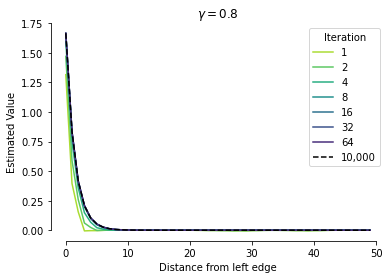

In [7]:
gamma = 0.8

# call the value iteration network
Q, V = ValueIterationNetwork.value_iteration(
    transition_functions = [sparse_diffusion_matrix],
    reward_functions = [R],
    n_rows = n_rows,
    n_columns = n_columns,
    gamma=gamma,
    iterations = iterations,
    return_interim_estimates = True
)

error_g08 = value_estimate_error(V)

plot_1d_value_estimates(V, gamma)
plt.savefig('1dDrift_g8.pdf', dpi=300)

  0%|          | 0/10000 [00:00<?, ?it/s]

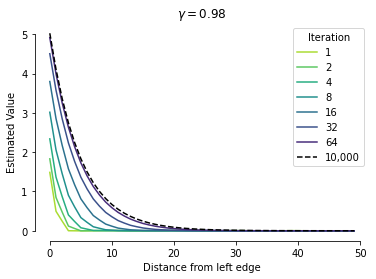

In [8]:
gamma = 0.98

# call the value iteration network
Q, V = ValueIterationNetwork.value_iteration(
    transition_functions = [sparse_diffusion_matrix],
    reward_functions = [R],
    n_rows = n_rows,
    n_columns = n_columns,
    gamma=gamma,
    iterations = iterations,
    return_interim_estimates = True
)

error_g098 = value_estimate_error(V)

plot_1d_value_estimates(V, gamma)
plt.savefig('1dDrift_g98.pdf', dpi=300)

  0%|          | 0/10000 [00:00<?, ?it/s]

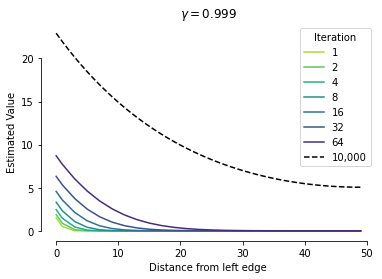

In [9]:
gamma = 0.999

# call the value iteration network
Q, V = ValueIterationNetwork.value_iteration(
    transition_functions = [sparse_diffusion_matrix],
    reward_functions = [R],
    n_rows = n_rows,
    n_columns = n_columns,
    gamma=gamma,
    iterations = iterations,
    return_interim_estimates = True
)

error_g0999 = value_estimate_error(V)


plot_1d_value_estimates(V, gamma)
plt.savefig('1dDrift_g999.pdf', dpi=300)

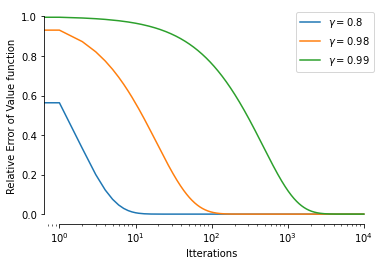

In [10]:
plt.plot(error_g08/np.max(error_g08), label=r'$\gamma = {}$'.format(0.8))
plt.plot(error_g098/np.max(error_g098), label=r'$\gamma = {}$'.format(0.98))
plt.plot(error_g0999/np.max(error_g0999), label=r'$\gamma = {}$'.format(0.99))
plt.xscale('log')
plt.legend()
plt.xlabel('Itterations')
plt.ylabel('Relative Error of Value function')
sns.despine(trim=True)
plt.savefig('gamma_complexity.pdf', dpi=300)



## Example 3: Needle in a Haystack
This is designed as an example that is difficult for MCTS but easy for Value iteration. Note: these are the first simulations to derive a meaningful policy (the above were diffusion policies).


In [253]:
# define the enviornment
n_rows, n_columns = 8, 8
movement_penalty = -0.10
slip_probability = 0.05

transition_functions, state_action_reward_functions, optimal_policy = environments.make_thread_the_needle(
    n_rows=n_rows,
    n_columns=n_columns,
    movement_penalty=movement_penalty,
    slip_probability=slip_probability
)


grid_shape = (n_rows, n_columns)

goal_state = 0
start_state = n_rows * n_columns - 1

  0%|          | 0/4 [00:00<?, ?it/s]

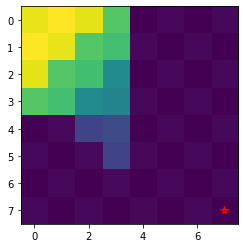

In [298]:
gamma = 0.99

common_model_kwargs = dict(
    transition_functions=transition_functions, 
    reward_functions=state_action_reward_functions,
    n_rows=n_rows, 
    n_columns=n_columns
)



Q, R = ValueIterationNetwork.value_iteration(gamma=gamma, **common_model_kwargs, iterations=4)
plt.imshow(R.reshape(n_rows, n_columns) )
plt.plot(n_rows-1, n_columns-1, '*', c='r', markersize=8)

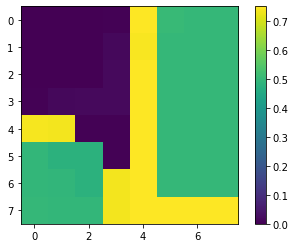

In [299]:
pi = ValueIterationNetwork.softmax(Q, beta=10)

fig, ax = plt.subplots()

pos  = ax.imshow(1-np.sum(optimal_policy * pi, axis=1).reshape(grid_shape))
fig.colorbar(pos,  ax=ax)



In [258]:
pi.dot(optimal_policy)

ValueError: shapes (64,4) and (64,4) not aligned: 4 (dim 1) != 64 (dim 0)

In [252]:
# construct optimal policy (not a pdf, but a binary vector corresponding to isOptimal)
# 0 = up, 1 = left, 2 = right, 3 = down

def get_state_from_position(row: int, column: int, n_columns: int) -> int:
    return n_columns * row + column

optimal_policy = np.zeros_like(Q, dtype=int)
indicator = np.zeros(n_rows * n_columns)



# In the first room, along the left wall
c = n_columns//2
for r in range(n_rows-1):
    state = get_state_from_position(r, c, n_columns)
    optimal_policy[state, :] = np.array([0, 0, 0, 1])
    indicator[state] = 1
    
# in the first room, along the bottom
r = n_rows - 1
for c in range(n_columns//2, n_columns):
    state = get_state_from_position(r, c, n_columns)
    optimal_policy[state, :] = np.array([0, 1, 0, 0])
    indicator[state] = 2


# everywhere else in the first room
for r in range(n_rows-1):
    for c in range(n_columns//2+1, n_columns):
        state = get_state_from_position(r, c, n_columns)
        optimal_policy[state, :] = np.array([0, 1, 0, 1])
        indicator[state] = 3
        
# first spot in second room
r = n_rows - 1
c = n_columns // 2 - 1
state = get_state_from_position(r, c, n_columns)
optimal_policy[state, :] = np.array([1, 0, 0, 0])
indicator[state] = 4

# along right wall in second room
c = n_columns//2 - 1
for r in range(n_rows // 2, n_rows-1):
    state = get_state_from_position(r, c, n_columns)
    optimal_policy[state, :] = np.array([1, 0, 0, 0])
    indicator[state] = 5
    
# along top wall in second room
r = n_rows // 2
for c in range(n_columns//2-1):
    state = get_state_from_position(r, c, n_columns)
    optimal_policy[state, :] = np.array([0, 0, 1, 0])
    indicator[state] = 6
    
# everywhere else in the second room
for r in range(n_rows // 2 + 1, n_rows):
    for c in range(n_columns // 2 - 1):
        state = get_state_from_position(r, c, n_columns)
        optimal_policy[state, :] = np.array([1, 0, 1, 0])
        indicator[state] = 7
        
# everywhere else 
for r in range(n_rows // 2):
    for c in range(n_columns //2):
        state = get_state_from_position(r, c, n_columns)
        optimal_policy[state, :] = np.array([1, 1, 0, 0])
        indicator[state] = 8

# goal state (overwrites previous value)
optimal_policy[0, :] = np.ones(4)
indicator[0] = 9

# optimal_policy
indicator.reshape(grid_shape)

array([[9., 8., 8., 8., 1., 3., 3., 3.],
       [8., 8., 8., 8., 1., 3., 3., 3.],
       [8., 8., 8., 8., 1., 3., 3., 3.],
       [8., 8., 8., 8., 1., 3., 3., 3.],
       [6., 6., 6., 5., 1., 3., 3., 3.],
       [7., 7., 7., 5., 1., 3., 3., 3.],
       [7., 7., 7., 5., 1., 3., 3., 3.],
       [7., 7., 7., 4., 2., 2., 2., 2.]])

In [218]:
indicator.shape

(16,)

In [192]:
# MLE policy
# 0 = up, 1 = left, 2 = right, 3 = down
np.argmax(Q, axis=1).reshape(n_rows, n_columns)

array([[0, 1, 1, 1, 3, 1, 1, 3],
       [0, 0, 1, 1, 3, 3, 3, 3],
       [0, 0, 0, 0, 3, 3, 3, 3],
       [0, 0, 1, 0, 3, 3, 3, 3],
       [2, 2, 2, 0, 3, 3, 3, 3],
       [0, 2, 0, 0, 3, 3, 1, 3],
       [0, 0, 0, 0, 3, 1, 1, 1],
       [0, 2, 0, 0, 1, 1, 1, 1]])

In [196]:
pi = ValueIterationNetwork.softmax(Q, beta=1e3)
pi.round(3)

array([[0.25 , 0.25 , 0.25 , 0.25 ],
       [0.   , 1.   , 0.   , 0.   ],
       [0.   , 1.   , 0.   , 0.   ],
       [0.   , 1.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 1.   ],
       [0.   , 0.93 , 0.   , 0.07 ],
       [0.   , 0.992, 0.   , 0.008],
       [0.013, 0.   , 0.013, 0.974],
       [1.   , 0.   , 0.   , 0.   ],
       [0.5  , 0.5  , 0.   , 0.   ],
       [0.001, 0.999, 0.   , 0.   ],
       [0.497, 0.503, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 1.   ],
       [0.   , 0.364, 0.   , 0.636],
       [0.   , 0.394, 0.   , 0.606],
       [0.   , 0.   , 0.   , 1.   ],
       [1.   , 0.   , 0.   , 0.   ],
       [0.999, 0.001, 0.   , 0.   ],
       [0.5  , 0.5  , 0.   , 0.   ],
       [1.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 1.   ],
       [0.   , 0.378, 0.   , 0.622],
       [0.   , 0.415, 0.   , 0.585],
       [0.   , 0.   , 0.   , 1.   ],
       [1.   , 0.   , 0.   , 0.   ],
       [0.503, 0.497, 0.   , 0.   ],
       [0.   , 1.   , 0.   , 0.   ],
 

In [124]:
trajectory = simulation_utils.sample_trajectory_until_goal(
    start_state, goals_state, np.argmax(Q, axis=1), transition_functions)
len(trajectory)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

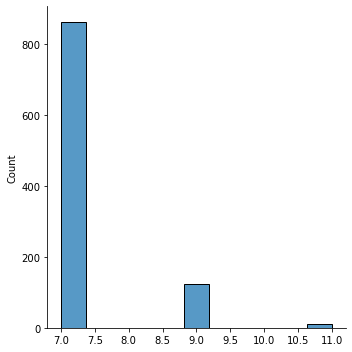

In [125]:
sns.displot(
    [len(simulation_utils.sample_trajectory_until_goal(start_state, goals_state, pi, transition_functions)) for _ in range(1000)]
)

In [126]:
goals_state
X = np.zeros_like(R)
X[goals_state] = 1
X = X.reshape((n_rows, n_columns))
r_g, c_g = np.argmax(X, axis=0).max(), np.argmax(X, axis=1).max()
d = np.abs(r_g - n_rows) + np.abs(c_g - n_columns)
print(f"Manhattan Distance from start to goal: {d}")

Manhattan Distance from start to goal: 8


In [127]:
%reload_ext autoreload
from models import ValueIterationNetwork, MCTS, GridWorldNode

node_kwargs = dict(
    end_states=[goals_state],
    transition_functions=transition_functions,
    state_reward_function=state_reward_function
)

mcts_kwargs = dict(
    end_states=[goals_state],
    transition_functions=transition_functions,
    state_reward_function=state_reward_function 
)
mcts = MCTS(**mcts_kwargs)



start_node = GridWorldNode(start_state, **node_kwargs)
a = start_node.expand()
# print(a)
# reward = start_node.simulate(a)
# print(reward)

# path = [(start_node, a)]


# start_node.update_child_values(a, reward)
# start_node.ucb_select_action()

In [181]:
# simulate search depths for thread the needle
simulations = []

iterations = 100

for s in tqdm(range(4, 21, 2)):

    n_rows, n_columns = s, s
    movement_penalty = -0.10
    slip_probability = 0.05

    transition_functions, state_action_reward_functions = environments.make_thread_the_needle(
        n_rows=n_rows,
        n_columns=n_columns,
        movement_penalty=movement_penalty,
        slip_probability=slip_probability
    )
    start_state = n_rows * n_columns - 1
    
    node_kwargs = dict(
    end_states=[goals_state],
    transition_functions=transition_functions,
    state_reward_function=state_reward_function
    )
    start_node = GridWorldNode(start_state, **node_kwargs)


    
    
    for ii in range(iterations):
#         depth = int(np.round((start_node.simulate(a) - 1) / movement_penalty))
        depth = start_node.get_simulation_depth()
        simulations.append({
            'Number of states': s**2,
            'Search Depth': depth,
            'Iteration': ii
        })
        
simulations = pd.DataFrame(simulations)

100%|██████████| 9/9 [06:00<00:00, 40.09s/it]


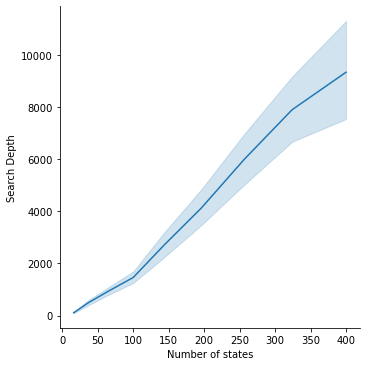

In [185]:
sns.relplot(x='Number of states', y='Search Depth', data=simulations, kind='line')


In [116]:
from tqdm import tnrange
for ii in tnrange(10):
    mcts.do_rollout(start_node)


<ipython-input-116-d8c4c022482f>:2: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for ii in tnrange(10):


  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [21]:
# 0 = up, 1 = left, 2 = right, 3 = down
mcts.get_policy().reshape((n_rows, n_columns))

array([[-1,  0,  1,  3],
       [ 0,  1,  2,  0],
       [ 1,  1,  2,  2],
       [ 3,  1,  3,  2]])